In [145]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as RBF_sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV, gp_minimize
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from gp_tools import GPPredictModel
import gp_tools

from casadi import *

In [2]:
%matplotlib notebook

# Load data

In [3]:
plans = []

names = ['kite_sampling_01']

dh_list = []
res = []
for name in names:
    load_name = '../sampling/{name}/{name}_plan.pkl'.format(name=name)
    plan = do_mpc.tools.load_pickle(load_name)
    
    dh = do_mpc.sampling.DataHandler(plan)
    dh.set_param(data_dir = '../sampling/{}/sample_results/'.format(name))

    dh.set_post_processing('input', lambda data: data['_u'])
    dh.set_post_processing('states', lambda data: data['_x'])
    dh.set_post_processing('wind', lambda data: data['_p'])
    dh.set_post_processing('T_F', lambda data: data['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data['_x'].shape[0])
    dh_list.extend(dh)
    res.extend(dh.filter(input_filter = lambda w_ref, E_0: np.abs(w_ref-10)<2 and np.abs(E_0-6)<2,
                        output_filter = lambda T_F: np.sum(T_F)/1e6>20))
    


---------------------------------------------------------------
Trying to access a non-existent element from the sampling plan.
---------------------------------------------------------------


In [4]:
len(res)

38

Only include data that satisfies certain conditions:

In [5]:
res_pd = pd.DataFrame(res)
res_pd.head(3)

,w_ref,E_0,h_min,seed,x0,id,input,states,wind,T_F,height,traj_len
0,10.953643,6.091611,95.100967,463,"[[1.2192922329037863], [0.6996672143951623], [...",000,"[[6.862405355210816], [9.353320432506655], [10...","[[1.2192922329037863, 0.6996672143951623, -0.3...","[[6.0872768549427425, 10.487860180192119], [6....","[[18929.338122699362], [11672.844666683484], [...","[[287.3111352903893], [287.07290665482753], [2...",200
1,8.294952,7.287200,111.246471,765,"[[0.7322457690565014], [0.8926083891975454], [...",004,"[[5.3955285783777365], [7.560199882010559], [8...","[[0.7322457690565014, 0.8926083891975454, 0.22...","[[7.265006093980835, 8.603838193907485], [7.25...","[[222066.8455218631], [167634.00237900967], [1...","[[167.77260931599628], [171.3633801694216], [1...",200
2,10.789213,7.754743,99.776706,268,"[[0.8527867049570851], [0.3678638736816997], [...",005,"[[6.163782180866716], [7.876381663746424], [8....","[[0.8527867049570851, 0.3678638736816997, 1.76...","[[7.741991467576186, 9.899266035689228], [7.74...","[[217013.27544139975], [181299.7142971376], [1...","[[281.09256299402824], [281.6685548120641], [2...",200


<IPython.core.display.Javascript object>


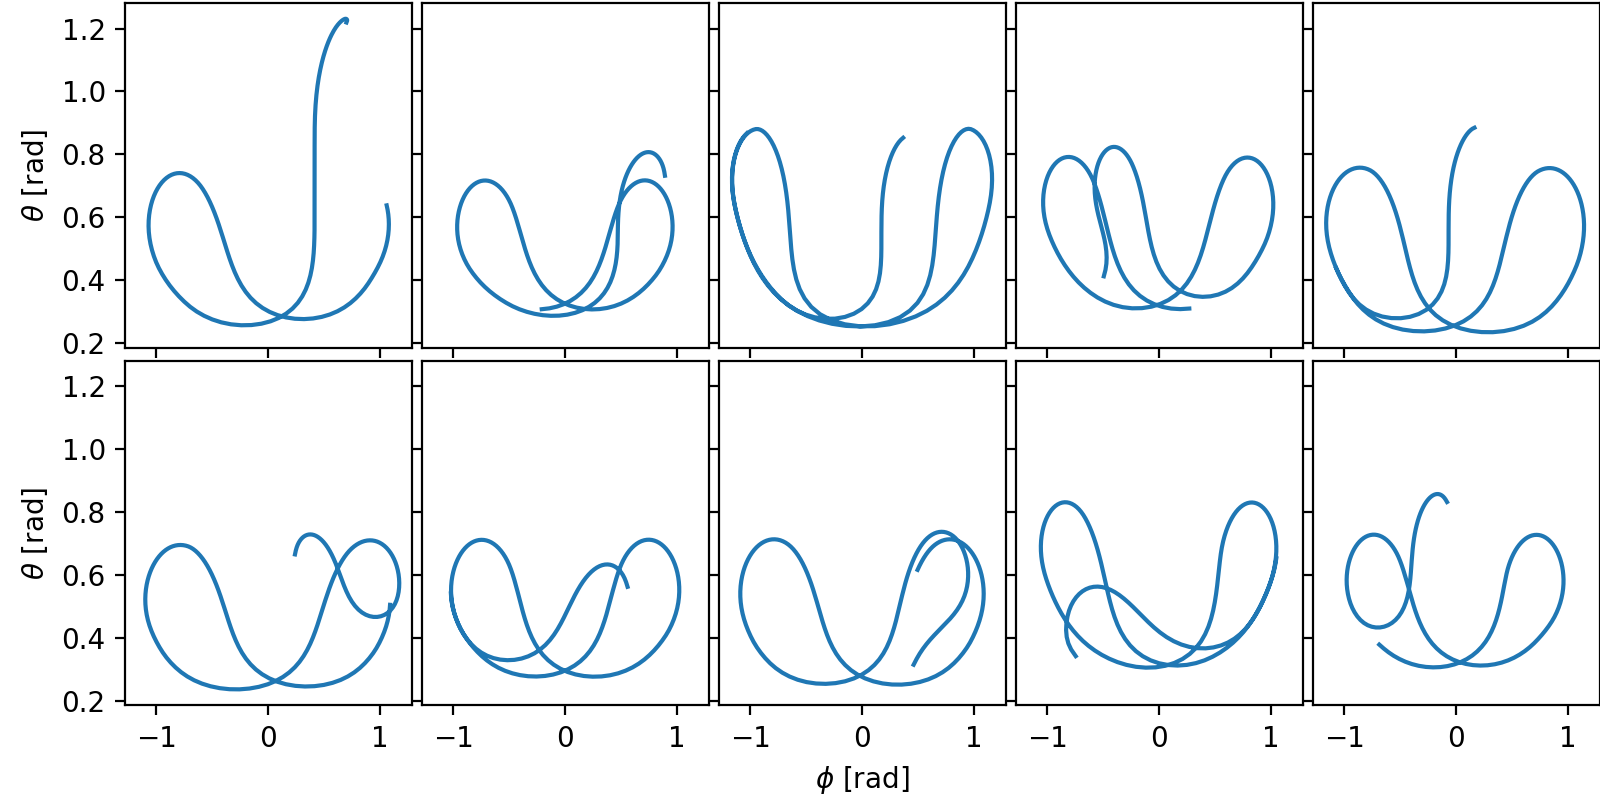

In [189]:
n_res = min(len(res),10)

n_row = int(np.ceil(np.sqrt(n_res)))
n_row = 2
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,4))
for i, res_i in enumerate(res[:n_res]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0])
    

ax[0,0].set_ylabel(r'$\theta$ [rad]')    
ax[1,0].set_ylabel(r'$\theta$ [rad]')  
ax[1,2].set_xlabel(r'$\phi$ [rad]')  
    
fig.tight_layout(pad=0)

fig.savefig('Kite_closed_loop_training_data.pdf', format='pdf', pad_inches=0)


# Data prep

In [7]:
nn_in = []
nn_out = []

n_test = 20
train_val_res = res[:-n_test]
test_res = res[-n_test:]


for i, res_i in enumerate(train_val_res):
    x_now = res_i['states'][:,:] # omit position as state

    nn_in.append(np.concatenate((res_i['input'], res_i['wind'], x_now),axis=1)[:-1,:])


    x_next = np.roll(res_i['states'],-1,axis=0)[:,:]
    dx = x_next - x_now

    nn_out.append(np.concatenate((res_i['T_F'], res_i['height'], dx),axis=1)[:-1,:])

n_traj = len(res)
    
    

    
nn_in = np.concatenate(nn_in)
nn_out = np.concatenate(nn_out)

nn_in_train, nn_in_test, nn_out_train, nn_out_test = train_test_split(nn_in, nn_out, test_size=0.1, random_state=42)


# Noise
np.random.seed(99)
noise_mag = 0.0
in_noise = np.max(np.abs(nn_in_train),axis=0)*noise_mag
out_noise = np.max(np.abs(nn_out_train),axis=0)*noise_mag

nn_in_train += in_noise*np.random.randn(*nn_in_train.shape)
nn_out_train += out_noise*np.random.randn(*nn_out_train.shape)
nn_in_test += in_noise*np.random.randn(*nn_in_test.shape)
nn_out_test += out_noise*np.random.randn(*nn_out_test.shape)

In [8]:
in_scaler = preprocessing.StandardScaler().fit(nn_in_train)
out_scaler = preprocessing.StandardScaler().fit(nn_out_train)

nn_in_train_scaled = in_scaler.transform(nn_in_train)
nn_out_train_scaled = out_scaler.transform(nn_out_train)

nn_in_test_scaled = in_scaler.transform(nn_in_test)
nn_out_test_scaled = out_scaler.transform(nn_out_test)

nn_in_train_scaled.shape

(3223, 6)

# GP über SKLearn

In [9]:
np.random.seed(99)
n_samples_gpr = 100
sample_ind = np.random.choice(np.arange(nn_in_train_scaled.shape[0]),n_samples_gpr)

X_grp = nn_in_train_scaled[sample_ind,:]
Y_grp = nn_out_train_scaled[sample_ind,:]

X_test = nn_in_test_scaled
Y_test = nn_out_test_scaled

alpha = 1e-10
gpr = GaussianProcessRegressor(kernel=RBF_sklearn(length_scale=0.1), alpha = alpha, random_state=0).fit(X_grp, Y_grp)

print(f'R2 score: {gpr.score(X_test, Y_test)}')

l = gpr.kernel_.length_scale

R2 score: 0.9532945390289517


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/base.py:426: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  warnings.warn("The default value of multioutput (not exposed in "


## Kite GP with CasADI 

In [10]:
case = 3

x0 = (test_res[case]['states'][0]).reshape(-1,1)

pm = GPPredictModel(gpr, in_scaler, out_scaler, x0)

for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm.make_step(u0,p)

<IPython.core.display.Javascript object>


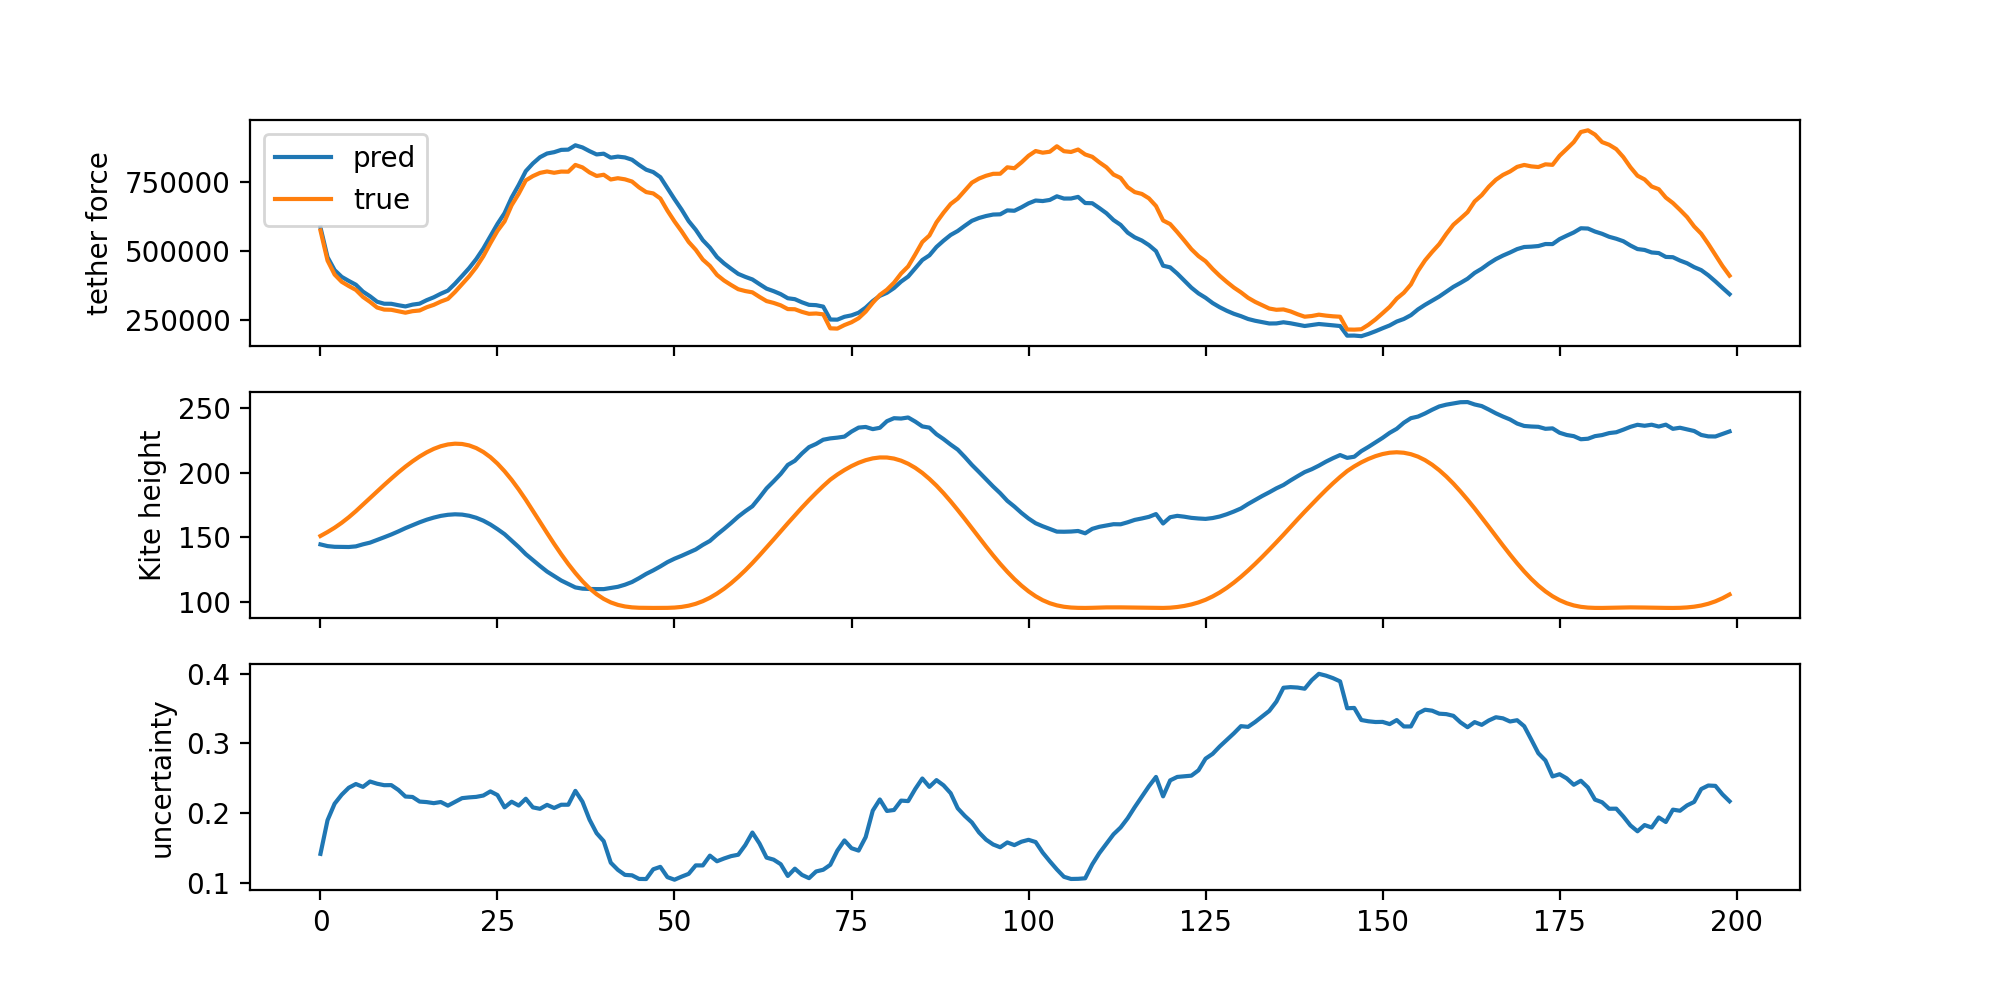

Text(0, 0.5, 'uncertainty')

In [11]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,5))

ax[0].plot(pm.aux[:,0],label='pred')
ax[0].plot(test_res[case]['T_F'], label='true')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm.aux[:,1])
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm.v)
ax[2].set_ylabel('uncertainty')

In [12]:
gp_traj = []
gp_trust = []
n_eval = min(20,len(test_res))

for i, res_i in enumerate(test_res[:n_eval]):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm = GPPredictModel(gpr, in_scaler, out_scaler, x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm.make_step(u0,p)
    
    gp_traj.append(pm.x)
    gp_trust.append(pm.v)

<IPython.core.display.Javascript object>


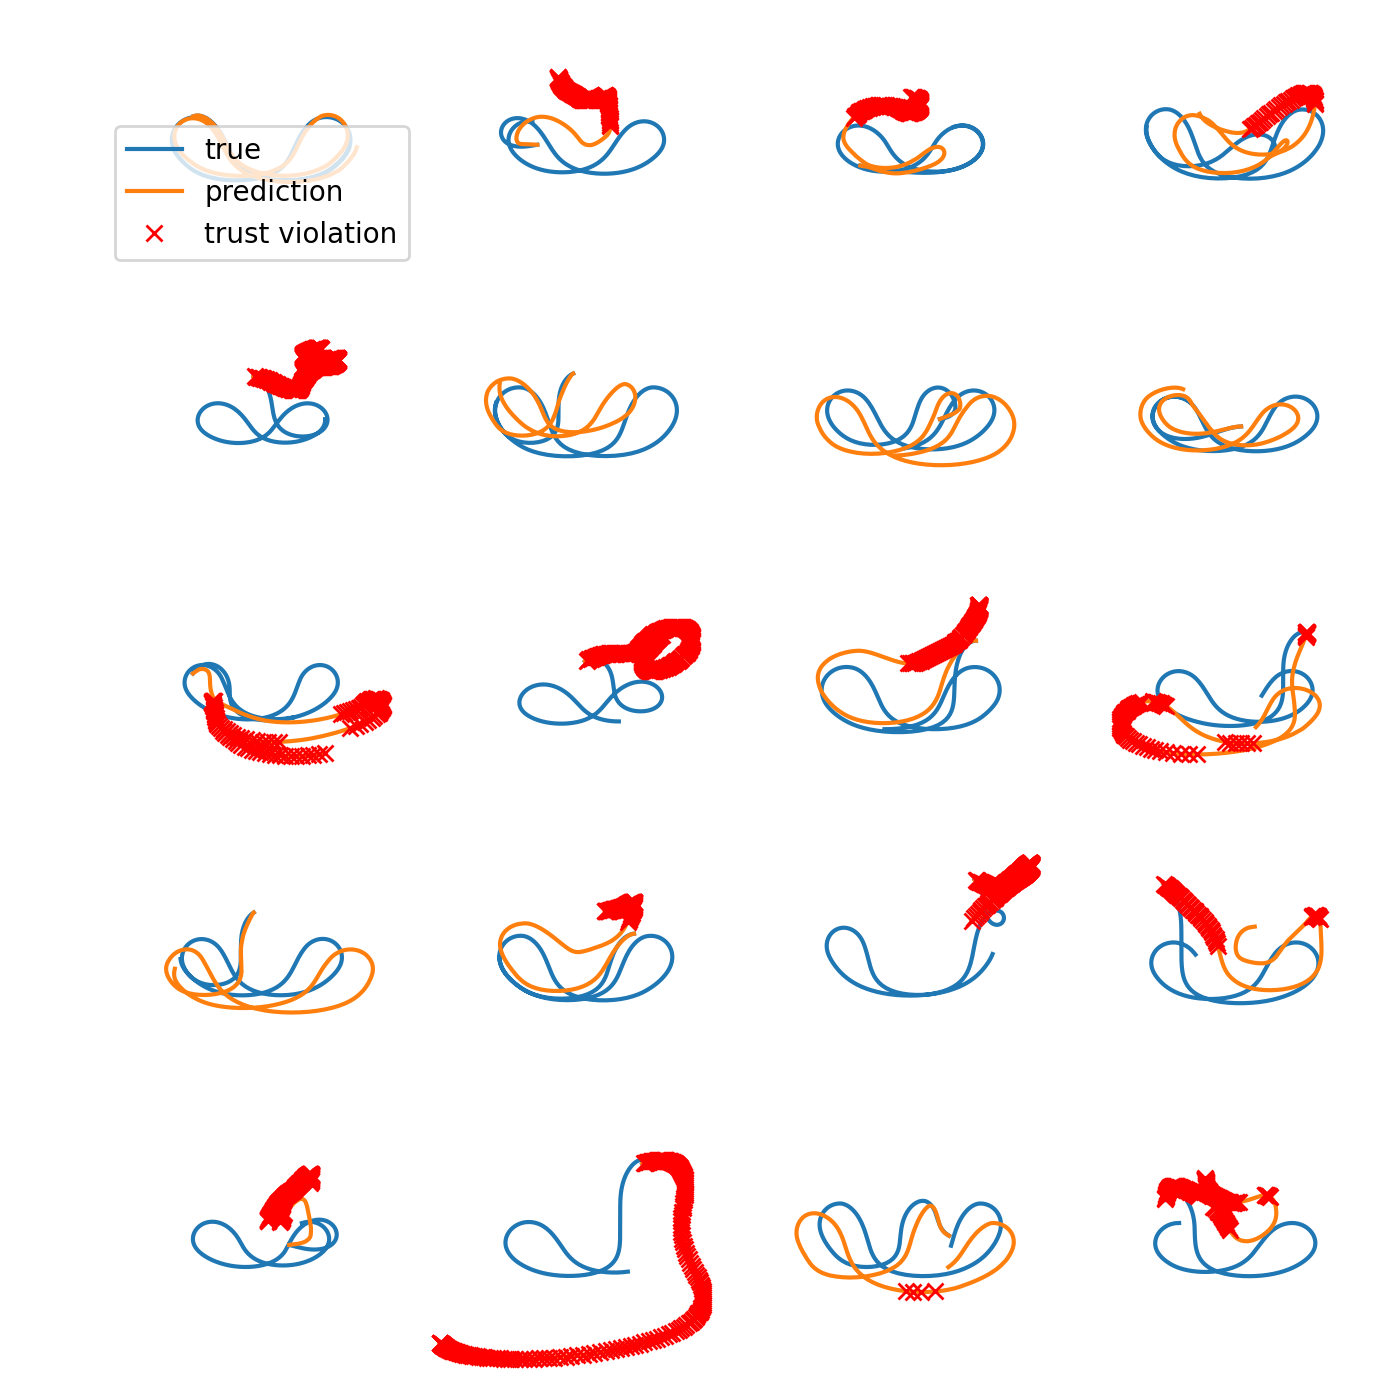

In [15]:
n_row = int(np.ceil(np.sqrt(n_eval)))
#n_row = 2
n_col = int(np.ceil(n_eval/n_row))

trust_threshold = 0.3


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(7,7))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0], label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj[i][:,1], gp_traj[i][:,0], label='prediction')
    
    viol_ind = (gp_trust[i]>= trust_threshold).flatten()
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj[i][1:,:][viol_ind,1], gp_traj[i][1:,:][viol_ind,0],
                                      'x', color='red', label='trust violation')
    
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

ax[0,0].legend()

fig.tight_layout()

# Export

In [14]:
export_name = 'S01_GP_M02_100'
export_path = './gp_models/{}/'
pathlib.Path(export_path.format(export_name)).mkdir(parents=True, exist_ok=True)

export_dict = {'X_train': X_grp, 'Y_train': Y_grp, 'l': l, 'alpha': alpha,
               'in_scaler': in_scaler, 'out_scaler': out_scaler}
do_mpc.tools.save_pickle(export_path.format(export_name) + export_name + '_gp.pkl', export_dict)

# Execution speed sklearn vs CasADi

In [152]:
gp_cas = gp_tools.GP(gp_tools.RBF(l=l))
gp_cas.fit(X_grp, Y_grp, Sigma=alpha*np.eye(X_grp.shape[0]))

In [167]:
y_hat_cas, v_cas = gp_cas.predict(X_test[[0],:])

In [169]:
y_hat_skl, v_skl = gpr.predict(X_test[[0],:], return_cov=True)

In [170]:
v_skl-v_cas

array([[5.92533181e-07]])

In [171]:
y_hat_cas-y_hat_skl

array([[ 1.50496997e-06, -2.15794483e-06,  1.76275486e-06,
        -2.34776861e-06, -1.60690546e-06]])

In [173]:
x = SX.sym('x',1,6)
y_hat_cas, v_cas = gp_cas.predict(x)

f = Function('f', [x], [y_hat_cas, v_cas])

In [175]:
%%timeit
f(X_test[[0],:])

108 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [176]:
%%timeit
gpr.predict(X_test[[0],:], return_cov=True)

127 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
